In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys
import os
from os import listdir
from os.path import isfile
import pickle

import tensorflow as tf
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn import svm
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

FLAGS = None
SAVE_PATH = '../../logdir/models'

model = 'mnist_cff_2000.ckpt'
SAVE_PATH = '../logdir/models'
ELITE_LOC = '../logdir/elites/mnist_test_elites_19:45:10_18-09-17'
DIAG_DIR = os.path.join(ELITE_LOC, 'diagrams')
TRUE_DIR = os.path.join(DIAG_DIR, 'true')
FALSE_DIR = os.path.join(DIAG_DIR, 'elites')

TAKE = 50

In [2]:
def break_filename(f):
    cls = int(f[0])
    pidx = f.index('.')
    uidx = f.index('_')
    idx = int(f[uidx+1:pidx])
    fname = f[:pidx]
    return cls, idx, fname

In [3]:
true_files = [f for f in listdir(TRUE_DIR) if isfile(os.path.join(TRUE_DIR, f))]
false_files = [f for f in listdir(FALSE_DIR) if isfile(os.path.join(FALSE_DIR, f))]

dummy = np.genfromtxt(os.path.join(TRUE_DIR, true_files[0]), delimiter=',').reshape(1,-1)
trues = np.empty(shape=(len(true_files), TAKE*2))
true_info = []
for i in range(len(true_files)):
    col={}
    temp = np.genfromtxt(os.path.join(TRUE_DIR, true_files[i]), delimiter=',')
    trues[i, :] = np.append(temp[:TAKE,0], temp[:TAKE,1], axis=0)
    cls, idx, _ = break_filename(true_files[i])
    col['cls'] = cls
    col['idx'] = idx
    true_info.append(col)
falses = np.empty(shape=(len(false_files),TAKE*2))
false_info = []
for i in range(len(false_files)):
    col = {}
    temp = np.genfromtxt(os.path.join(FALSE_DIR, false_files[i]), delimiter=',')
    falses[i, :] = np.append(temp[:TAKE,0], temp[:TAKE,1], axis=0)
    cls, idx, _ = break_filename(false_files[i])
    col['cls'] = cls
    col['idx'] = idx
    false_info.append(col)

true_info = pd.DataFrame(true_info)
false_info = pd.DataFrame(false_info)
totes = np.vstack((trues, falses)).reshape((-1,TAKE*2), order='F')
totes_labels = np.empty(shape=(totes.shape[0], 1))
totes_labels[0::2, :] = 1
totes_labels[1::2, :] = 0

train_im = totes[:-100,:]
train_lab = totes_labels[:-100,:]

test_im = totes[-100:,:]
test_lab = totes_labels[-100:,:]

In [4]:
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10)
kmeans.fit(trues)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [5]:
res = []
for i in range(true_info.shape[0]):
    col = {}
    col['t_score'] = kmeans.score(trues[i,:].reshape(1,-1))
    col['f_score'] = kmeans.score(falses[i,:].reshape(1,-1))
    col['f_c'] = kmeans.predict(falses[i,:].reshape(1,-1))[0]
    col['t_c'] = kmeans.predict(trues[i,:].reshape(1,-1))[0]
    col['distance_f'] = np.linalg.norm(col['f_c'] - falses[i,:])
    col['distance_t'] = np.linalg.norm(col['t_c'] - trues[i,:])
    res.append(col)
resdf = pd.DataFrame(res)

In [6]:
resdf.head()

,distance_f,distance_t,f_c,f_score,t_c,t_score
0,75.554183,3.134180,8,-1.143036,0,-0.345813
1,66.787824,6.628193,7,-0.354220,1,-0.144097
2,6.758090,16.492097,1,-0.656766,2,-0.312378
3,76.038007,36.689044,8,-0.432699,4,-0.474619
4,6.710337,36.918474,1,-0.208352,4,-0.616686


In [7]:
resdf['tgf'] = resdf['t_score'] > resdf['f_score']
resdf['tgfd'] = resdf['distance_t'] > resdf['distance_f']

In [8]:
np.sum(resdf['tgf'])/resdf.shape[0]
np.sum(resdf['tgfd'])/resdf.shape[0]

0.42705005324813633

In [9]:
centroid_diagrams = []
for j in range(len(kmeans.cluster_centers_)):
    births = []
    deaths = []
    for i in range(kmeans.cluster_centers_[j].shape[0]):
        c = kmeans.cluster_centers_[j]
        if i % 2 == 0:
            births.append(c[i])
        else:
            deaths.append(c[i])
    yx = np.column_stack((births,deaths))
    centroid_diagrams.append(yx)

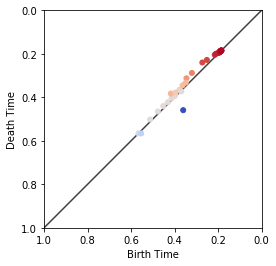

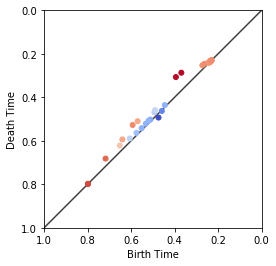

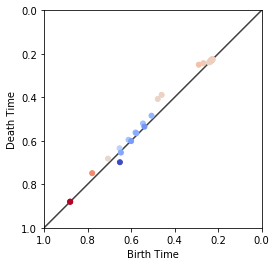

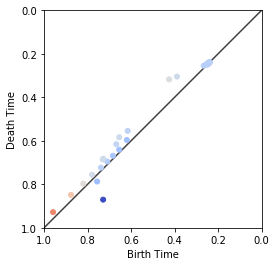

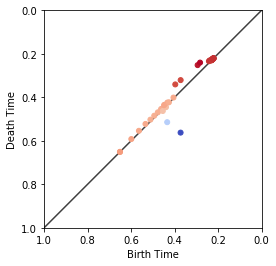

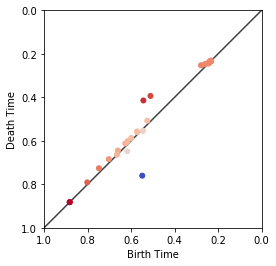

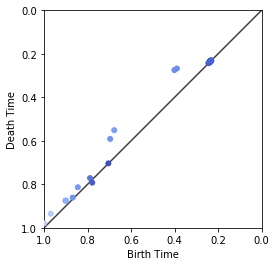

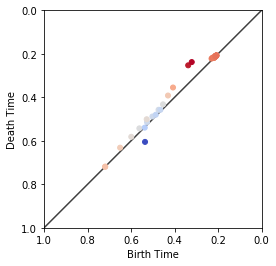

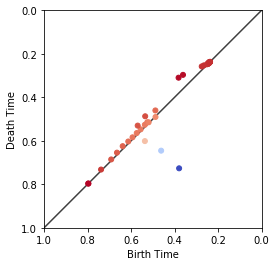

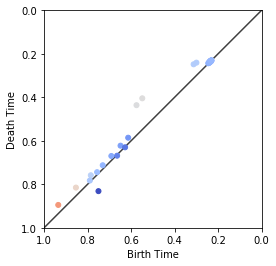

In [10]:
for yx in centroid_diagrams:
    fig, ax = plt.subplots()
    ax.scatter(yx[:,0], yx[:,1], s=25, c=yx[:,0]**2 - yx[:,1], cmap=plt.cm.coolwarm, zorder=10)
    lims = [
        np.min([1]),  # min of both axes
        np.max([0]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.xlabel('Birth Time')
    plt.ylabel('Death Time')
    plt.show()